# Model for Average and StDev

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (5,3)
import tqdm
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import pylab as pl
from matplotlib import collections  as mc
from sklearn.preprocessing import StandardScaler
#import warnings
#warnings.filterwarnings("ignore")

import sys

google_colab = 1
if google_colab == 1:
    # Load the Drive helper and mount
    from google.colab import drive
    mounted_path_folder = '/content/drive'
    drive.mount(mounted_path_folder, force_remount=True)
    path_folder = "/content/drive/MyDrive/dsprojects/dsproject_ff_geo/archive/" # parent of current src folder
else:
    path_folder = "..//..//"

sys.path.insert(0, path_folder+"/src/dataclean")
import util

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Data File Reading

In [3]:

path_folder_data = os.path.join(path_folder, "data")
path_folder_data_raw = os.path.join(path_folder_data,"raw")
path_folder_data_temp = os.path.join(path_folder_data,"temp")
path_folder_data_final = os.path.join(path_folder_data,"final")

file_name_oa_offers = "offer_acceptance_offers.csv"
path_file_oa_offers = os.path.join(path_folder_data_raw, file_name_oa_offers)
oa_offers = pd.read_csv(path_file_oa_offers)
print("Loaded offers df")
print(oa_offers.shape)

file_name_oa_orders = "offer_acceptance_orders.csv"
path_file_oa_orders = os.path.join(path_folder_data_raw, file_name_oa_orders)
oa_orders = pd.read_csv(path_file_oa_orders)
print("Loaded orders df")
print(oa_orders.shape)

file_name_zipcode_coordinates = "zipcode_coordinates.csv"
path_file_zipcode_coordinates = os.path.join(path_folder_data_raw, file_name_zipcode_coordinates)
zipcode_coordinates = pd.read_csv(path_file_zipcode_coordinates)
print("Loaded zipcodes df")
print(zipcode_coordinates.shape)

Loaded offers df
(707418, 14)
Loaded orders df
(280906, 17)
Loaded zipcodes df
(896, 3)


## Data Cleaning

In [4]:
# Distance over order time depends on Time between Order and Deadline
# Lead Time depends on Time between Order and Deadline
# 

In [5]:
include_lead_time = 1
weighing_by_lead_time = 1
revamp_weighing_by_lead_time = 0
cut_off_lead_time = 0


include_outliers = 1
include_path_columns = 1
include_sparse_orders = 1

avoid_pooled_reference_numbers = 0
filtering_ftl = 0
explode_references = 1
do_pooled_model = 1

bundled_shared_train_test_split = 0
do_oversample = 1
include_zipcode_endpoint_enrich_columns = 1
include_estimated_cost = 1
do_zscore = 1

include_geodata_columns = 1
only_mainland_us = 1
do_shared_train_test_split = 1
drop_prelogged = 1
model_soph = 1

# = [0,0,0,0,0]+[0,0,1,0,1] is sd and num separable pca

# temporary columns. ALWAYS KEEP THESE SET TO 1
include_zipcode_coords_columns = 1
include_metro_cluster_columns = 1
include_time_ohe_columns = 1
include_distance_column = 1
include_duration_column = 1
include_distance_over_duration_column = 1
do_log = 1
do_ohe = 1
drop_preohe = 1

# mutually exclusive factors
if cut_off_lead_time != 0:
    include_lead_time = 1
if weighing_by_lead_time:
    include_lead_time = 1
if bundled_shared_train_test_split:
    do_oversample = 0
if do_oversample:
    bundled_shared_train_test_split = 0
if do_pooled_model == 1:
    avoid_pooled_reference_numbers = 0
    filtering_ftl = 0
    explode_references = 1
if avoid_pooled_reference_numbers == 1:
    do_pooled_model = 0
if filtering_ftl == 1:
    do_pooled_model = 0
if explode_references == 0:
    do_pooled_model = 0

In [6]:
# data cleaning offers
# In this part, I'm just adding columns to the oa offers table

oa_offers_boolean_column_names = ['LOAD_DELIVERED_FROM_OFFER']
#oa_offers_boolean_column_names += ['SELF_SERVE', 'IS_OFFER_APPROVED','AUTOMATICALLY_APPROVED', 'MANUALLY_APPROVED', 'WAS_EVER_UNCOVERED','COVERING_OFFER', 'LOAD_DELIVERED_FROM_OFFER', 'RECOMMENDED_LOAD', 'VALID']

# Only a few columns are needed from the offers dataset:
# RATE_USD must be kept for the average rates
# LOAD_DELIVERED_FROM_OFFER must be kept for lead time
# CREATED_ON_HQ must be kept for lead time
# OFFER_TYPE must be kept for the pooled column

oa_offers_date_column_names = ["CREATED_ON_HQ"]
oa_offers_categorical_column_names = ["OFFER_TYPE"]
oa_offers_loggable_numerical_column_names = ["RATE_USD"]
oa_offers_numerical_column_names = []
oa_offers_ohe_column_names = []

oa_offers = util.add_cleaned_reference_numbers_column(oa_offers)
oa_offers = util.add_num_reference_numbers_column(oa_offers)
oa_offers = util.dataclean_pool_reference_numbers_discrepancy(oa_offers)


offer_type_is_pooled_column_name = "OFFER_TYPE_IS_POOLED"
oa_offers = util.add_offer_type_is_pooled_column(oa_offers,column_name=offer_type_is_pooled_column_name)
oa_offers_boolean_column_names += [offer_type_is_pooled_column_name]

oa_offers_selected_column_names = ["REFERENCE_NUMBER","REFERENCE_NUMBERS"]
oa_offers_selected_column_names += oa_offers_date_column_names # has CREATED_ON_HQ
oa_offers_selected_column_names += oa_offers_boolean_column_names # has LOAD_DELIVERED_FROM_OFFER and OFFER_TYPE_IS_POOLED
oa_offers_selected_column_names += oa_offers_loggable_numerical_column_names # has RATE_USD
oa_offers_selected_column_names += oa_offers_numerical_column_names # has nothing
oa_offers = oa_offers[oa_offers_selected_column_names]
# subsets the column names


for column_name in oa_offers_date_column_names: oa_offers = util.convert_pd_datetime_column(oa_offers, column_name);
for column_name in oa_offers_boolean_column_names: oa_offers = util.convert_boolean_to_num_column(oa_offers, column_name);
for column_name in oa_offers_loggable_numerical_column_names: oa_offers = util.add_log_column_to_df(oa_offers, column_name,drop_prelogged=True);

In [7]:
# data cleaning orders
# In this part, I'm just adding columns to the oa orders table

oa_orders_categorical_column_names = ["DELIVERY_TIME_CONSTRAINT","TRANSPORT_MODE"]
# column names contained in this categorical column names list are those that plan to be one-hot-encoded later on
oa_orders_ohe_column_names = []

oa_orders_boolean_column_names = ['FD_ENABLED', 'EXCLUSIVE_USE_REQUESTED','HAZARDOUS', 'REEFER_ALLOWED', 'STRAIGHT_TRUCK_ALLOWED','LOAD_TO_RIDE_REQUESTED']
# column names contained in this boolean column names list are those that will be treated as boolean
oa_orders_loggable_numerical_column_names = ["ESTIMATED_COST_AT_ORDER","PALLETIZED_LINEAR_FEET","LOAD_BAR_COUNT"]
if include_estimated_cost == 0: oa_orders_loggable_numerical_column_names.remove("ESTIMATED_COST_AT_ORDER");
# column names contained in this loggable numerical column names list are those that plan to be log-transformed later on
oa_orders_numerical_column_names = []
# column names contained in this numerical column names list are those that are numerical but shouldn't be log transformed

oa_orders_date_column_names = ["ORDER_DATETIME_PST","PICKUP_DEADLINE_PST"] # ORDER_DATETIME_PST is necessary for lead time






zipcode_coordinates["X_COORD"] /= 1.0e6
zipcode_coordinates["Y_COORD"] /= 1.0e6
# dividing zipcode coordinates to make their numbers smaller

zipcode_coordinates["3DIGIT_ZIP"] = zipcode_coordinates["3DIGIT_ZIP"].astype(int).astype(str).str.zfill(3)
# convert the zipcodes to be 3-digit, zeropadded strings

if include_zipcode_coords_columns:
    # adds 2 new columns to the orders dataset: X_COORD_DEST, Y_COORD_DEST, which are the x, y coordinates of the order's destination zipcode
    # also adds their column names to the (not loggable) numerical column names 
    oa_orders = (
        oa_orders
        .merge(zipcode_coordinates, left_on=["DESTINATION_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
        .rename(columns={"X_COORD":"X_COORD_DEST","Y_COORD":"Y_COORD_DEST"})
        .drop(columns=["3DIGIT_ZIP"])
    )

    # adds 2 new columns to the orders dataset: X_COORD_ORIG, Y_COORD_ORIG, which are the x, y coordinates of the order's origin zipcode
    # also adds their column names to the (not loggable) numerical column names 
    oa_orders = (
        oa_orders
        .merge(zipcode_coordinates, left_on=["ORIGIN_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
        .rename(columns={"X_COORD":"X_COORD_ORIG","Y_COORD":"Y_COORD_ORIG"})
        .drop(columns=["3DIGIT_ZIP"])
    )
    oa_orders_numerical_column_names += ["X_COORD_ORIG","Y_COORD_ORIG","X_COORD_DEST","Y_COORD_DEST"]
if only_mainland_us == 1:
    # Crops the dataset to exclude Hawaii and Alaska
    Y_UPPER_BOUND = 6.5
    Y_LOWER_BOUND = 2.5
    X_UPPER_BOUND = -7
    X_LOWER_BOUND = -15

    oa_orders = oa_orders[((oa_orders["X_COORD_ORIG"] >= X_LOWER_BOUND) & (oa_orders["X_COORD_ORIG"] <= X_UPPER_BOUND))]
    oa_orders = oa_orders[((oa_orders["X_COORD_DEST"] >= X_LOWER_BOUND) & (oa_orders["X_COORD_DEST"] <= X_UPPER_BOUND))]
    oa_orders = oa_orders[((oa_orders["Y_COORD_ORIG"] >= Y_LOWER_BOUND) & (oa_orders["Y_COORD_ORIG"] <= Y_UPPER_BOUND))]
    oa_orders = oa_orders[((oa_orders["Y_COORD_DEST"] >= Y_LOWER_BOUND) & (oa_orders["Y_COORD_DEST"] <= Y_UPPER_BOUND))]


if filtering_ftl:
    # filters orders data so that the only rows have FTL for TRANSPORT_MODE
    oa_orders = util.dataclean_filter_ftl(oa_orders)
    # drop transport mode column from categorical column names list
    # since all of the column names in categorical column names list are being planned to get one hot encoded
    # and since TRANSPORT MODE would only be just FTL, that would accidentally create a 1-category one-hot-encoding, which we don't want 
    oa_orders_categorical_column_names.remove("TRANSPORT_MODE")


# Matt said that any duplicate references is likely an error
oa_orders = util.dataclean_ftl_duplicate_references(oa_orders)
oa_orders = util.add_cleaned_reference_numbers_column(oa_orders)

if include_distance_column:
    # adds a new column APPROXIMATE_DRIVING_ROUTE_MILEAGE to orders dataset, 
    # which the euclidean distance between the x,y coordinates of origin and destination of order 
    distance_column_name = "APPROXIMATE_DRIVING_ROUTE_MILEAGE"
    oa_orders = util.add_distance_column(oa_orders,column_name=distance_column_name)
    oa_orders_loggable_numerical_column_names += [distance_column_name]

if include_duration_column:
    # adds a new column TIME_BETWEEN_ORDER_AND_DEADLINE to orders dataset, which is duration between order and pickup 
    time_between_order_and_deadline_column_name = "TIME_BETWEEN_ORDER_AND_DEADLINE"
    oa_orders = util.add_time_between_2_events_column(oa_orders,column_name=time_between_order_and_deadline_column_name)
    oa_orders_loggable_numerical_column_names += [time_between_order_and_deadline_column_name]
    #oa_orders_numerical_column_names += [time_between_order_and_deadline_column_name]

if include_distance_over_duration_column:
    # divides the log-transformed APPROXIMATE_DRIVING_ROUTE_MILEAGE by the log-transformed TIME_BETWEEN_ORDER_AND_DEADLINE
    distance_over_order_time_column_name = "DISTANCE_OVER_ORDER_TIME"
    oa_orders = util.add_distance_over_time_column(oa_orders,column_name=distance_over_order_time_column_name)
    oa_orders_numerical_column_names += [distance_over_order_time_column_name]

if include_geodata_columns:
    # add the geoenrichment data about the shipping routes
    file_name_route_data = "paths_geoenriched.csv"
    path_file_route_data = os.path.join(path_folder_data_raw, file_name_route_data)
    route_df = pd.read_csv(path_file_route_data)
    route_df = util.add_log_column_to_df(route_df,"OPER_COUNT",drop_prelogged=True)
    temp_foreign_key_column_names = ["REFERENCE_NUMBER"]
    oa_orders = oa_orders.merge(route_df,on=temp_foreign_key_column_names,how="left")
    shipping_route_geoenrichment_data_column_names = list(route_df.drop(columns=temp_foreign_key_column_names).columns)
    oa_orders_numerical_column_names += shipping_route_geoenrichment_data_column_names

if include_time_ohe_columns:
    # adds time-based columns for one-hot-encoding.
    # it specifically gets the month number, weekday number, and hour number, for the order datetime and deadline datetime 
    # then appends the new column names to the categorical column names list, so that it will be processed for one-hot-encoding later
    month_column_name = "DEADLINE_MONTH"
    oa_orders = util.add_month_column(oa_orders, date_column_name="PICKUP_DEADLINE_PST", column_name=month_column_name)
    oa_orders_categorical_column_names += [month_column_name]

    weekday_column_name = "DEADLINE_DAY"
    oa_orders = util.add_weekday_column(oa_orders, date_column_name="PICKUP_DEADLINE_PST", column_name=weekday_column_name)
    oa_orders_categorical_column_names += [weekday_column_name]

    hour_column_name = "DEADLINE_HOUR"
    oa_orders = util.add_hour_column(oa_orders, date_column_name="PICKUP_DEADLINE_PST", column_name=hour_column_name)
    oa_orders_categorical_column_names += [hour_column_name]

    month_column_name = "ORDER_MONTH"
    oa_orders = util.add_month_column(oa_orders, date_column_name="ORDER_DATETIME_PST", column_name=month_column_name)
    oa_orders_categorical_column_names += [month_column_name]

    weekday_column_name = "ORDER_DAY"
    oa_orders = util.add_weekday_column(oa_orders, date_column_name="ORDER_DATETIME_PST", column_name=weekday_column_name)
    oa_orders_categorical_column_names += [weekday_column_name]

    hour_column_name = "ORDER_HOUR"
    oa_orders = util.add_hour_column(oa_orders, date_column_name="ORDER_DATETIME_PST", column_name=hour_column_name)
    oa_orders_categorical_column_names += [hour_column_name]


if include_zipcode_endpoint_enrich_columns:
    # adds census data column about the origin and destination zipcodes
    zip5_csv = pd.read_csv(os.path.join(path_folder,"src","dataclean","Zipcode-ZCTA-Population-Density-And-Area-Unsorted.csv"))
    zip5_csv["3DIGIT_ZIP"] = zip5_csv["Zip/ZCTA"].astype(float).astype(int).astype(str).str.zfill(5).str[:3]
    zip3_census = zip5_csv.groupby(["3DIGIT_ZIP"],as_index=False).agg({"2010 Population":np.sum,"Land-Sq-Mi":np.sum})
    zip3_census["POPDEN_LOG"] = ((np.log1p(zip3_census["2010 Population"]))/(np.log1p(zip3_census["Land-Sq-Mi"])+1))
    zip3_census["POPDEN"] = (((zip3_census["2010 Population"]))/((zip3_census["Land-Sq-Mi"])+1))
    zip3_census["LOG(POPDEN)"] = np.log1p(zip3_census["POPDEN"])
    zip3_census = (
            zip3_census
            .merge(zipcode_coordinates, on=["3DIGIT_ZIP"])
            .rename(columns={"X_COORD":"X_COORD_CENSUS","Y_COORD":"Y_COORD_CENSUS"})
            #.drop(columns=["3DIGIT_ZIP"])
        )
    zip3_census = zip3_census[((zip3_census["X_COORD_CENSUS"] >= X_LOWER_BOUND) & (zip3_census["X_COORD_CENSUS"] <= X_UPPER_BOUND))]
    zip3_census = zip3_census[((zip3_census["Y_COORD_CENSUS"] >= Y_LOWER_BOUND) & (zip3_census["Y_COORD_CENSUS"] <= Y_UPPER_BOUND))]

    zip3_census_orig = zip3_census.rename(columns={"X_COORD_CENSUS":"X_COORD_ORIG",
                                          "Y_COORD_CENSUS":"Y_COORD_ORIG",
                                          "LOG(POPDEN)":"ORIG_ZIP_LOG(POPDEN)"})[["X_COORD_ORIG","Y_COORD_ORIG","ORIG_ZIP_LOG(POPDEN)"]]
    zip3_census_dest = zip3_census.rename(columns={"X_COORD_CENSUS":"X_COORD_DEST",
                                          "Y_COORD_CENSUS":"Y_COORD_DEST",
                                          "LOG(POPDEN)": "DEST_ZIP_LOG(POPDEN)"})[["X_COORD_DEST","Y_COORD_DEST","DEST_ZIP_LOG(POPDEN)"]]
    oa_orders = oa_orders.merge(zip3_census_orig,on=["X_COORD_ORIG","Y_COORD_ORIG"])
    oa_orders = oa_orders.merge(zip3_census_dest,on=["X_COORD_DEST","Y_COORD_DEST"])
    oa_orders_numerical_column_names += ["ORIG_ZIP_LOG(POPDEN)","DEST_ZIP_LOG(POPDEN)"]





oa_orders_selected_column_names = ["REFERENCE_NUMBER","REFERENCE_NUMBERS","DESTINATION_3DIGIT_ZIP","ORIGIN_3DIGIT_ZIP"]
oa_orders_selected_column_names += oa_orders_date_column_names
oa_orders_selected_column_names += oa_orders_boolean_column_names
oa_orders_selected_column_names += oa_orders_loggable_numerical_column_names
oa_orders_selected_column_names += oa_orders_categorical_column_names
oa_orders_selected_column_names += oa_orders_numerical_column_names
oa_orders = oa_orders[oa_orders_selected_column_names]
# subsets the column names


if do_ohe:
    # if do_ohe is true, goes through each of the categorical column names listed, applies pandas get_dummies to it, and concatenates it to the data
    for column_name in oa_orders_categorical_column_names:
        ohe_columns = util.temp_build_ohe(oa_orders[column_name],column_name=column_name)
        ohe_column_names = list(ohe_columns.columns)
        oa_orders_ohe_column_names += ohe_column_names
        oa_orders = util.add_ohe_columns(oa_orders, ohe_columns)
        if drop_preohe: 
            # if drop_preohe is true, the original categorical column will be dropped
            # which ensures that the input data matrix will be FULLY numerical by the time we put it into the model
            oa_orders.drop(columns=[column_name],inplace=True)

if do_log:
    # if do_log is true, adds a logged version of the columns in oa_orders_loggable_numerical_column_names
    for column_name in oa_orders_loggable_numerical_column_names: 
        # if drop_prelogged is true, the original pre-logged version of the column will be dropped
        oa_orders = util.add_log_column_to_df(oa_orders, column_name,drop_prelogged=drop_prelogged);
for column_name in oa_orders_date_column_names: 
    oa_orders = util.convert_pd_datetime_column(oa_orders, column_name);
for column_name in oa_orders_boolean_column_names: 
    oa_orders = util.convert_boolean_to_num_column(oa_orders, column_name);

Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in
removing 110 negative duration rows


In [8]:
# Joining the oa_offers and oa_orders into a new table called oa


# The offers data (oa_offers) and orders data (oa_orders) will be joined as follows:
# since orders to offers is one-to-many, the offers data needs to be groupby'd into a new table where each row corresponds to an order
# and THEN the orders and the offers-aggregation will be joined together.
# The offers-aggregation will bring the avg of the (log-transformed) rates, the stdev of the (log-transformed) rates, to the order
# the amount of offers per order will also be a new column

# both 2 tables will use the column REFERENCE_NUMBERS as the joining key
# Since REFERENCE_NUMBERS is actually a column where each value is a LIST of ids (in both tables), 
# it needs to be exploded using pandas explode before beinng joined (and for oa_offers, it needs to be exploded before the groupby, maybe)

log_rate_usd_column_name = "LOG(RATE_USD)"
count_reference_numbers_column_name = "ORDER_OFFER_AMOUNT"
sd_log_rate_usd_column_name = "SD_LOG(RATE_USD)"
# adding a duplicate of the rates column to apply standard deviaton later on during the group by
oa_offers[sd_log_rate_usd_column_name] = oa_offers[log_rate_usd_column_name]
##adding a column for offer amount to do count later on during the group by
oa_offers[count_reference_numbers_column_name] = 1

print("revisit oa_orders.drop_duplicates(subset=[REFERENCE_NUMBER])")
#oa_orders = oa_orders.drop_duplicates(subset=["REFERENCE_NUMBER"])

if explode_references:
    foreign_key_column_name = "REFERENCE_NUMBERS"
    # Recall that in oa_orders, the column "REFERENCE_NUMBERS" are lists of reference number strings,
    # But for the case of oa_orders, these lists are just 1 item, so exploding REFERENCE_NUMBERS is no different 
    # than just doing oa_orders["REFERENCE_NUMBERS"] = oa_orders["REFERENCE_NUMBERS"].apply(lambda x: x[0])
    assert (type(oa_orders["REFERENCE_NUMBERS"].values[0]) == list)
    assert oa_orders["REFERENCE_NUMBERS"].apply(len).max() == 1
    assert oa_orders["REFERENCE_NUMBERS"].apply(len).min() == 1
    assert ((oa_orders["REFERENCE_NUMBERS"].apply(len)).sum() == oa_orders.shape[0])
    oa_orders_exploded = oa_orders.explode(["REFERENCE_NUMBERS"])
    assert ((oa_orders.shape[0] == oa_orders_exploded.shape[0])) 
    # row count for the pre- and post-exploded references would be unchanged since the lists are just 1 item
    assert (type(oa_orders_exploded["REFERENCE_NUMBERS"].values[0]) == str) 

    # Recall that in oa_offers, the column "REFERENCE_NUMBERS" are lists of reference number strings
    assert (type(oa_offers["REFERENCE_NUMBERS"].values[0]) == list)
    # So we should apply the pandas explode function to the REFERENCE_NUMBERS column in oa_offers
    oa_offers_exploded = oa_offers.explode(["REFERENCE_NUMBERS"])
    # Now, oa_offers has more rows post_explosion, and reference numbers are now strings
    assert (type(oa_offers_exploded["REFERENCE_NUMBERS"].values[0]) == str)
    assert ((oa_offers["REFERENCE_NUMBERS"].apply(len)).sum() == oa_offers_exploded.shape[0])
else:
    # else, join by the original reference number column 
    foreign_key_column_name = "REFERENCE_NUMBER"
    oa_offers_exploded = oa_offers
    oa_orders_exploded = oa_orders

if filtering_ftl == 1:
    oa_offers_exploded = oa_offers_exploded[oa_offers_exploded["OFFER_TYPE_IS_POOLED"]==0]
else:
    if do_ohe:
        oa_offers_exploded = oa_offers_exploded.merge(oa_orders_exploded[["TRANSPORT_MODE=FTL",foreign_key_column_name]],on=[foreign_key_column_name])
        oa_offers_exploded = oa_offers_exploded[((oa_offers_exploded["TRANSPORT_MODE=FTL"]==1) & (oa_offers_exploded["OFFER_TYPE_IS_POOLED"])!=1)]
        oa_offers_exploded.drop(columns=["TRANSPORT_MODE=FTL"],inplace=True)
    else:
        oa_offers_exploded = oa_offers_exploded.merge(oa_orders_exploded[["TRANSPORT_MODE",foreign_key_column_name]],on=[foreign_key_column_name])
        oa_offers_exploded = oa_offers_exploded[((oa_offers_exploded["TRANSPORT_MODE"]=="FTL") & (oa_offers_exploded["OFFER_TYPE_IS_POOLED"])!=1)]
        oa_offers_exploded.drop(columns=["TRANSPORT_MODE"],inplace=True)

# now, the newly exploded oa_offers must be groupby'd on REFERENCE_NUMBERS to be in the same joinable level as oa orders
aggdict = dict()
aggdict[log_rate_usd_column_name] = np.mean 
aggdict[sd_log_rate_usd_column_name] = np.std # standard deviation
aggdict["OFFER_TYPE_IS_POOLED"] = np.mean
aggdict[count_reference_numbers_column_name] = np.sum
#aggdict[count_reference_numbers_column_name] = "count"
oa_offers_exploded_groupby = oa_offers_exploded.groupby([foreign_key_column_name],as_index=False).agg(aggdict)
oa_offers_exploded_groupby = oa_offers_exploded_groupby.fillna(0) # fixes any accidental nan's in the stdev

temp_oa_orders = oa_orders_exploded
temp_oa_offers = oa_offers_exploded_groupby
oa = temp_oa_orders.merge(temp_oa_offers, on=[foreign_key_column_name])

revisit oa_orders.drop_duplicates(subset=[REFERENCE_NUMBER])


Do not drop ORDER_OFFER_AMOUNT column before clustering the metro areas


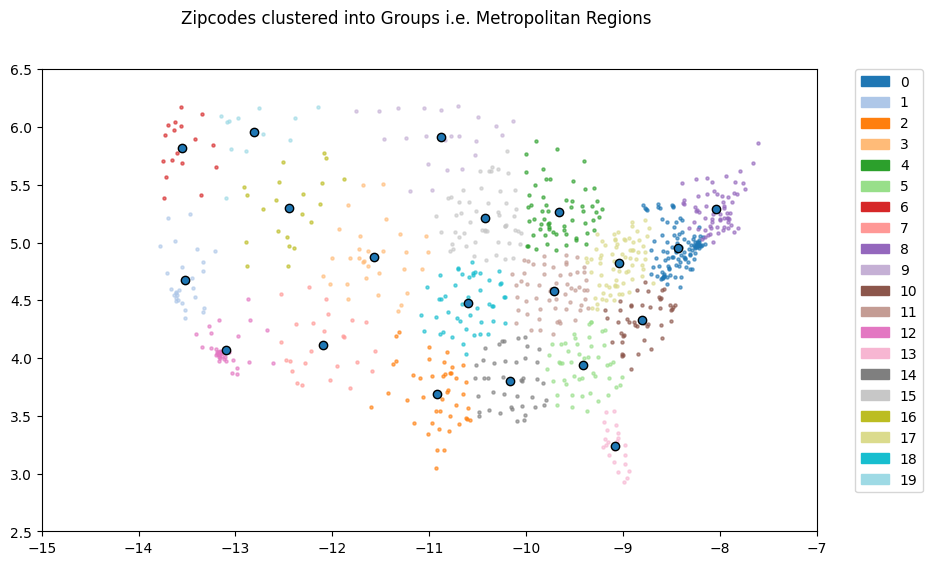

Do not drop ORDER_OFFER_AMOUNT column before clustering the metro areas
Do not drop ORDER_OFFER_AMOUNT column before clustering the metro areas
(187661, 173)
Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in
(163761, 174)


In [9]:
oa_boolean_column_names = []
oa_loggable_numerical_column_names = []
oa_numerical_column_names = []
oa_categorical_column_names = []
oa_ohe_column_names = []

if include_metro_cluster_columns:
    # adds the set of columns that encode the origin zipcode of an order to different metropolitan region groups
    metro_cluster = util.temp_build_metro_cluster(oa)
    orig_proximity_column_names = ["ORIG_"+metro_cluster.group_column_name+"="+str(i) for i in range(metro_cluster.group_amount)]
    orig_metro_cluster_columns = util.temp_build_metro_cluster_columns(oa, metro_cluster,"X_COORD_ORIG","Y_COORD_ORIG",orig_proximity_column_names)
    oa = util.add_metro_cluster_columns(oa, orig_metro_cluster_columns)
    oa_numerical_column_names += orig_proximity_column_names

    # adds the set of columns that encode the destination zipcode of an order to different metropolitan region groups
    dest_proximity_column_names = ["DEST_"+metro_cluster.group_column_name+"="+str(i) for i in range(metro_cluster.group_amount)]
    dest_metro_cluster_columns = util.temp_build_metro_cluster_columns(oa, metro_cluster,"X_COORD_DEST","Y_COORD_DEST",dest_proximity_column_names)
    oa = util.add_metro_cluster_columns(oa, dest_metro_cluster_columns)
    oa_numerical_column_names += dest_proximity_column_names

print(oa.shape)
lead_time_column_name = "LEAD_TIME"
weight_column_name = None
if include_lead_time == True:
    # adds the lead time percentage column to the data to be used for sample_weights or normalization for the model
    # note that the lead-time column WON'T be a feature used in the input matrix used to train the model itself in the function fit, but rather for the
    # sample_weights argument
    assert "CREATED_ON_HQ" in list(oa_offers_exploded.columns)
    assert "LOAD_DELIVERED_FROM_OFFER" in list(oa_offers_exploded.columns)
    oa = util.add_lead_time_column(oa, oa_offers_exploded, 
                                   column_name=lead_time_column_name,
                                   reference_number_column_name=foreign_key_column_name)
if weighing_by_lead_time == True:
    weight_column_name = lead_time_column_name
print(oa.shape)

# necessary for path visualizations, which have a LOG(ORDER_OFFER_AMOUNT) column name
oa = util.add_log_column_to_df(oa, count_reference_numbers_column_name, drop_prelogged=False)

In [10]:
# Optional factors. All of these can only be done after oa join
if include_sparse_orders == 0:
    # reduces the dataset to only have orders with more than 5 offers
    oa = oa[oa["ORDER_OFFER_AMOUNT"]>=5]

if cut_off_lead_time != 0:
    # reduces the dataset to only have orders with a lead_time percentage greater than or equal to 'cut_off_lead_time', which is set to 50%
    oa = oa[oa["LEAD_TIME"]>=cut_off_lead_time]
    _ = plt.hist(oa["LEAD_TIME"])
if include_outliers == 0:
    # reduces the dataset to not have any orders with a large outlier offer amount
    oa = oa[oa["ORDER_OFFER_AMOUNT"]<=20]
if include_path_columns == 1:
    # adds new columns about shipping routes to the dataset. But these are just for data visualizations, and not used to train the model; they will get dropped
    path_groupby = util.temp_build_path_groupby(oa)
    oa = util.add_path_columns_to_df(oa)

{'PATH_AVG_LOG(RATE_USD)': <function mean at 0x7ff0280c15e0>, 'PATH_ORDER_AMOUNT': 'count', 'PATH_AVG_LOG(ORDER_OFFER_AMOUNT)': <function mean at 0x7ff0280c15e0>, 'PATH_AVG_ORDER_OFFER_AMOUNT': <function mean at 0x7ff0280c15e0>, 'PATH_AVG_LOG(OPER_COUNT)': <function mean at 0x7ff0280c15e0>, 'PATH_AVG_LOG(TEMPERATURE)': <function mean at 0x7ff0280c15e0>}
{'PATH_AVG_LOG(RATE_USD)': <function mean at 0x7ff0280c15e0>, 'PATH_ORDER_AMOUNT': 'count', 'PATH_AVG_LOG(ORDER_OFFER_AMOUNT)': <function mean at 0x7ff0280c15e0>, 'PATH_AVG_ORDER_OFFER_AMOUNT': <function mean at 0x7ff0280c15e0>, 'PATH_AVG_LOG(OPER_COUNT)': <function mean at 0x7ff0280c15e0>, 'PATH_AVG_LOG(TEMPERATURE)': <function mean at 0x7ff0280c15e0>}


In [11]:
from sklearn.preprocessing import KBinsDiscretizer

def view_path_visualization(path_groupby, agg_column_name):
    #path_agg_column_names = ['PATH_OFFER_AMOUNT', 'PATH_AVG_OFFER_AMOUNT','PATH_ORDER_AMOUNT',
    #       'LOG(PATH_AVG_OFFER_AMOUNT)', 'LOG(PATH_OFFER_AMOUNT)', 'LOG(PATH_ORDER_AMOUNT)', "LOG(RATE_USD)"]
    connections = path_groupby
    lines = []
    for i in range(connections.shape[0]):
        row = connections.iloc[i]
        ox = row["X_COORD_ORIG"]#.values[0]
        oy = row["Y_COORD_ORIG"]#.values[0]
        dx = row["X_COORD_DEST"]#.values[0]
        dy = row["Y_COORD_DEST"]#.values[0]
        lines.append([(ox, oy), (dx, dy)])
    values = connections[agg_column_name].values

    # create a sample numpy array|
    # define the number of bins
    num_bins = 4

    # perform binning using scikit-learn
    est = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
    values = est.fit_transform(values.reshape(-1, 1)).flatten()

    use_median = 0
    if use_median == 1:
        median = np.median(values)
        values = (values >= median).astype(float)
        cmap_choice = "cool"
        linewidths_array = ((connections[agg_column_name]+1)**2)*0.5
    else:
        cmap_choice = "viridis"
        linewidths_array = 0.1 #connections[agg_column_name]
    lc = mc.LineCollection(lines, 
                           array = values,
                           cmap=cmap_choice,
                           linewidths = linewidths_array,
                           alpha=0.2
                          )
    fig, axs = plt.subplots(figsize=(20,10))
    axs = util.bound_ax(axs)
    axs.scatter(connections["X_COORD_ORIG"], connections["Y_COORD_ORIG"], alpha=0.5, c="yellow", s=2)
    axs.scatter(connections["X_COORD_DEST"], connections["Y_COORD_DEST"], alpha=0.5, c="blue", s=2)
    axs.add_collection(lc)
    #ax2.autoscale()
    axs.margins(0.1)
    axs.set_title("Shipping Routes by {0}".format(agg_column_name))
    fig.colorbar(lc)
    return fig, axs
def map_zipcoords_by_value(oa, temp_value_column_name, temp_func=lambda x:x):

    temp_value_func = np.mean
    temp_both_zipcode_stacked = pd.concat([
    (oa[
        ["X_COORD_DEST","Y_COORD_DEST",temp_value_column_name]
                       ]
    ).rename(columns={
        "X_COORD_DEST": "X_COORD",
        "Y_COORD_DEST": "Y_COORD",
    }),

    (oa[
        ["X_COORD_ORIG","Y_COORD_ORIG",temp_value_column_name]
                       ]
    ).rename(columns={
        "X_COORD_ORIG": "X_COORD",
        "Y_COORD_ORIG": "Y_COORD",
    })
    ],axis=0)
    temp_both_zipcode_groupby = temp_both_zipcode_stacked.groupby(
        ["X_COORD","Y_COORD"],as_index=False
    ).agg({temp_value_column_name: temp_value_func})
    geotemp = temp_both_zipcode_groupby

    fig, axs = plt.subplots(figsize=(20,10))
    axs = util.bound_ax(axs)
    print(geotemp.shape)
    z = geotemp[temp_value_column_name]
    z = temp_func(z)
    m = axs.scatter(geotemp["X_COORD"],geotemp["Y_COORD"],cmap="viridis",alpha=0.5,c=z,s=(z+1)*40)
    #axs.set_title("Zipcodes by Average Offer-Amount per Order \n (Normalized by Shipping Route Order Amount)")
    #axs.set_title("Destination Zipcodes by Logged Sum Offer-Amount")
    cbar = fig.colorbar(m)
    cbar.set_alpha(1)
    #plt.show()
    return fig, axs
def temp_func(x):
    num_bins = 3
    values = x.values
    # perform binning using scikit-learn
    est = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
    values = est.fit_transform(values.reshape(-1, 1)).flatten()
    return values
#fig, axs = map_zipcoords_by_value(oa, "LOG(ORDER_OFFER_AMOUNT)",temp_func)
#axs.set_title("Zipcodes by Avg Offer Amount Seen per Order (Log-normal)", fontsize=30)
#plt.savefig(os.path.join(path_folder,"path_avg_num1.svg"),format="svg")

In [12]:
#fig, axs = map_zipcoords_by_value(oa, "LOG(ORDER_OFFER_AMOUNT)",temp_func)
#axs.set_title("Zipcodes by Avg Offer Amount Seen per Order (Log-normal)", fontsize=30)
#plt.show()
#plt.xticks([]) 
#plt.yticks([]) 
#plt.savefig(os.path.join(path_folder,"zip_avg_num2.svg"),format="svg")

In [13]:
#fig, axs = view_path_visualization(path_groupby, "PATH_AVG_LOG(RATE_USD)")
#axs.set_title("Shipping Routes by Avg. Offer Rates seen per Order (Log-normal)",fontsize=30)
#plt.savefig(os.path.join(path_folder,"path1_avg_rate.svg"),format="svg")
#plt.show()
#plt.xticks([]) 
#plt.yticks([]) 
#plt.savefig(os.path.join(path_folder,"path_avg_rate4.svg"),format="svg")

In [14]:
#fig, axs = view_path_visualization(path_groupby, "PATH_AVG_LOG(TEMPERATURE)")
#axs.set_title("Shipping Routes by Average Temperature",fontsize=30)
#plt.show()

In [15]:
# At this point, no more new columns should be added to oa,
# Any changes to oa's column schema at this point should only be about DROPPING columns

dropped_column_names = []

dropped_column_names +=[
    'ORDER_DATETIME_PST', 
    'PICKUP_DEADLINE_PST',
    'ORIGIN_3DIGIT_ZIP', 
    'DESTINATION_3DIGIT_ZIP',
    #'LOG(ESTIMATED_COST_AT_ORDER)',
    'REFERENCE_NUMBERS',
    'REFERENCE_NUMBER',
    'CREATED_ON_HQ'
]

if include_path_columns:
    # adds the path columns added purely for data visualization to the list of column names to be dropped.
    dropped_column_names += list(path_groupby.columns)[4:]
for column_name in dropped_column_names:
    if column_name in list(oa.columns):
        oa = oa.drop(columns=[column_name])
# drops the column names in dropped_column_names
# At this point, oa should FULLY have numerical column names
# However, if the variable do_ohe was set to False, then the categorical column names are still waiting to be encoded.

In [16]:
# By running these 2 lines, we are assuming all columns of oa are now numerical, and that categorical features have all been one-hot-encoded into boolean features
oa.replace([np.inf, -np.inf], np.nan, inplace=True)
oa.fillna(0, inplace=True)

In [17]:
from sklearn.preprocessing import StandardScaler

normalizable_column_names = []
normalizable_column_names += oa_orders_numerical_column_names
normalizable_column_names += oa_numerical_column_names
normalizable_column_names += ["LOG({0})".format(x) for x in oa_orders_loggable_numerical_column_names]
if drop_prelogged == 0: 
    normalizable_column_names += oa_orders_loggable_numerical_column_names

if do_zscore:
    oa[normalizable_column_names] = StandardScaler().fit_transform(oa[normalizable_column_names])

In [18]:
target_column_names=[
    "ORDER_OFFER_AMOUNT",
    "LOG(ORDER_OFFER_AMOUNT)",
    "LOG(RATE_USD)",
    "SD_LOG(RATE_USD)",
    "OFFER_TYPE_IS_POOLED",
]
if include_lead_time:
    target_column_names += ["LEAD_TIME"]

In [19]:
seed = 1
np.random.seed(seed)

assert do_shared_train_test_split == True

if do_shared_train_test_split:
    if bundled_shared_train_test_split:
        splitter = pd.DataFrame(np.arange(oa.shape[0]),columns=["idx"])
        y_bundled_column = oa[["OFFER_TYPE_IS_POOLED","LOG(ORDER_OFFER_AMOUNT)","SD_LOG(RATE_USD)"]]
        y_bundled_column["OFFER_TYPE_IS_POOLED"] = (oa["OFFER_TYPE_IS_POOLED"]>=0.5).astype(int)
        y_bundled_column["LOG(ORDER_OFFER_AMOUNT)"] = (oa["LOG(ORDER_OFFER_AMOUNT)"]>np.median(oa["LOG(ORDER_OFFER_AMOUNT)"])).astype(int)
        y_bundled_column["SD_LOG(RATE_USD)"] = (oa["SD_LOG(RATE_USD)"]>np.median(oa["SD_LOG(RATE_USD)"])).astype(int)
        np.random.seed(1)
        X_train, X_test, Y_train, Y_test  = train_test_split(splitter,y_bundled_column,stratify=y_bundled_column,test_size=0.2)
        temp_train_test_indexer = np.zeros(oa.shape[0])
        temp_train_test_indexer[X_train["idx"].values] = 1
    else:
        np.random.seed(seed)
        temp_train_test_indexer = np.random.choice([1,0],size=oa.shape[0],p=[4/5,1/5])
else:
    temp_train_test_indexer = None 

In [20]:
if revamp_weighing_by_lead_time:
    all_numerical_column_names = normalizable_column_names + oa_orders_ohe_column_names + oa_orders_boolean_column_names
    temp_oa = oa.copy()
    temp_oa_train_all_numericals = temp_oa.loc[temp_train_test_indexer==1,all_numerical_column_names] 
    temp_oa.loc[temp_train_test_indexer==1,all_numerical_column_names]  *= temp_oa.loc[temp_train_test_indexer==1,"LEAD_TIME"].values.reshape(-1,1)
    weighing_by_lead_time = 0
    weight_column_name = None

LOG(RATE_USD)
sample_weights will be used

Cross Val Scores: [0.74591568 0.70511825 0.7248767  0.65950511 0.66778704]
Corr between Regression Predicted Y & Actual Y: 0.8813624988876387


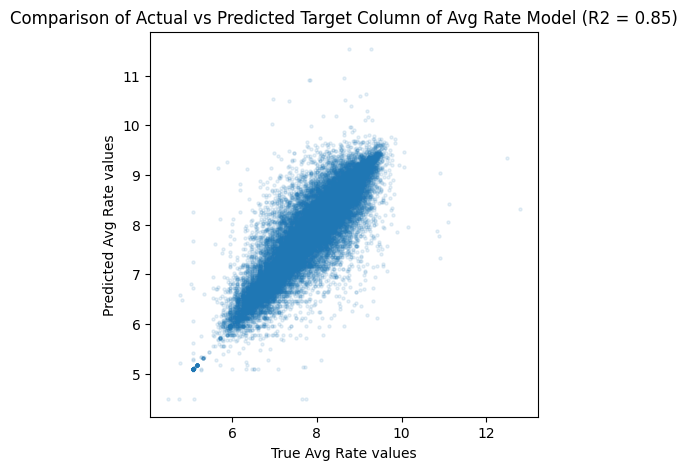



OFFER_TYPE_IS_POOLED
sample_weights will be used

Cross Val Scores: [0.96186778 0.96186323 0.96081891 0.96274064]
Confusion Matrix:
 [[0.86868437 0.13131563]
 [0.35549269 0.64450731]]
ROC AUC Score 0.7565958404717203
0.8106442064145991


ORDER_OFFER_AMOUNT
sample_weights will be used

Cross Val Scores: [0.8393018  0.83293634 0.83275434 0.83087036]
percentiles [3.0]
Confusion Matrix:
 [[0.56645669 0.43354331]
 [0.34615576 0.65384424]]
ROC AUC Score 0.6101504651472107
0.6199761970154719


SD_LOG(RATE_USD)
sample_weights will be used

Cross Val Scores: [0.8264923  0.82743902 0.8270985  0.82837219]
Confusion Matrix:
 [[0.64664397 0.35335603]
 [0.41847926 0.58152074]]
ROC AUC Score 0.6140823545111607
0.614208550764442


In [21]:


if model_soph == 0:
    model = LinearRegression()
else:
    model = DecisionTreeRegressor()

temp_target_column_names = target_column_names.copy()
target_column_name="LOG(RATE_USD)"
print(target_column_name)
temp_target_column_names.remove(target_column_name)
if weighing_by_lead_time:
    temp_target_column_names.remove(weight_column_name)
input_df = oa.drop(columns=temp_target_column_names)



avg_model_builder = util.Temp_Order_Regression_Model_Builder(
    df=input_df,
    target_column_name=target_column_name,
    weight_column_name=weight_column_name,
)
avg_model_builder.transform_y(inplace=True,update_df=True)
avg_model_builder.transform_X(inplace=True,top_n=30)
avg_model_builder.set_split(train_test_indexer=temp_train_test_indexer)

avg_model_builder.train_model(model)
predictions = avg_model_builder.test_model()
avg_model_builder.eval_model(predictions)

fig, axs = plt.subplots(figsize=(5,5))
axs.scatter(avg_model_builder.y_test, predictions,alpha=0.1,s=5)
axs.set_xlabel("True Avg Rate values")
axs.set_ylabel("Predicted Avg Rate values")
axs.set_title("Comparison of Actual vs Predicted Target Column of Avg Rate Model (R2 = 0.85)")
plt.show()
print("\n")
if do_pooled_model == 1:

    if model_soph == 0:
        model = LogisticRegression(class_weight="balanced")
    else:
        model = RandomForestClassifier(10,class_weight="balanced")

    temp_target_column_names = target_column_names.copy()
    target_column_name="OFFER_TYPE_IS_POOLED"
    print(target_column_name)

    temp_target_column_names.remove(target_column_name)
    if weighing_by_lead_time:
        temp_target_column_names.remove(weight_column_name)

    input_df = oa.drop(columns=temp_target_column_names)
    input_df[target_column_name] = (input_df[target_column_name]>=0.5).astype(int)
    pooled_model_builder = util.Temp_Order_Classification_Model_Builder(
        df=input_df,
        target_column_name=target_column_name,
        weight_column_name=weight_column_name
    )
    #pooled_model_builder.transform_y(inplace=True,update_df=True)
    pooled_model_builder.transform_X(inplace=True,top_n=30)
    pooled_model_builder.set_split(train_test_indexer=temp_train_test_indexer)
    if do_oversample:
        pooled_model_builder.oversample_class_imbalance()
    pooled_model_builder.train_model(model)
    #pooled_model_builder.train_model(RandomForestClassifier(10))
    predictions = pooled_model_builder.test_model()
    pooled_model_builder.eval_model(predictions)
    print((pooled_model_builder.y_test == pooled_model_builder.model.predict(pooled_model_builder.X_test)).mean())
print("\n")
temp_target_column_names = target_column_names.copy()
target_column_name="ORDER_OFFER_AMOUNT"
print(target_column_name)

temp_target_column_names.remove(target_column_name)
if weighing_by_lead_time:
    temp_target_column_names.remove(weight_column_name)
input_df = oa.drop(columns=temp_target_column_names)
predicted_avg_column = avg_model_builder.model.predict(
    input_df[avg_model_builder.top_n_correlated_selected_column_names])
input_df["PRED_LOG(RATE_USD)"] = predicted_avg_column
num_model_builder = util.Temp_Order_Classification_Model_Builder(
    df=input_df,
    target_column_name=target_column_name,
    weight_column_name=weight_column_name
)
num_model_builder.transform_y(inplace=True)
num_model_builder.transform_X(inplace=True,top_n=30)
#num_model_builder.X *= (np.expand_dims(input_df["LOG(TIME_BETWEEN_ORDER_AND_DEADLINE)"].values, axis=1))
num_model_builder.set_split(train_test_indexer=temp_train_test_indexer)
if do_oversample:
    num_model_builder.oversample_class_imbalance()
#num_model_builder.train_model(LogisticRegression(class_weight="balanced"))
#num_model_builder.train_model(RandomForestClassifier(10))
num_model_builder.train_model(RandomForestClassifier(10,class_weight="balanced"))

print("percentiles", num_model_builder.percentiles)
predictions = num_model_builder.test_model()
num_model_builder.eval_model(predictions)
print((num_model_builder.y_test == num_model_builder.model.predict(num_model_builder.X_test)).mean())
print("\n")


temp_target_column_names = target_column_names.copy()
target_column_name="SD_LOG(RATE_USD)"
print(target_column_name)

temp_target_column_names.remove(target_column_name)
if weighing_by_lead_time:
    temp_target_column_names.remove(weight_column_name)
input_df = oa.drop(columns=temp_target_column_names)

predicted_avg_column = avg_model_builder.model.predict(
    input_df[avg_model_builder.top_n_correlated_selected_column_names])
#predicted_avg_column = (oa["LOG(RATE_USD)"])
input_df["PRED_LOG(RATE_USD)"] = predicted_avg_column

predicted_num_column = num_model_builder.model.predict(
    input_df[num_model_builder.top_n_correlated_selected_column_names])
#predicted_num_column = (oa["ORDER_OFFER_AMOUNT"])
input_df["PRED_ORDER_OFFER_AMOUNT"] = predicted_num_column

if do_pooled_model == 1:
    predicted_pooled_column = pooled_model_builder.model.predict(
        input_df[pooled_model_builder.top_n_correlated_selected_column_names])
    #predicted_pooled_column = (oa["OFFER_TYPE_IS_POOLED"]).astype(float)
    input_df["PRED_IS_POOLED"] = predicted_pooled_column

sd_model_builder = util.Temp_Order_Classification_Model_Builder(
    df=input_df,
    target_column_name=target_column_name,
    weight_column_name=weight_column_name,
    #class_amount=3
)
sd_model_builder.transform_y(np.sqrt(sd_model_builder.y), inplace=True)
sd_model_builder.transform_X(inplace=True,top_n=30)
sd_model_builder.set_split(train_test_indexer=temp_train_test_indexer)
#sd_model_builder.train_model(LogisticRegression(class_weight="balanced"))
sd_model_builder.train_model(RandomForestClassifier(20,class_weight="balanced"))

predictions = sd_model_builder.test_model()
sd_model_builder.eval_model(predictions)
print((sd_model_builder.y_test == predictions).mean())

In [22]:
print(pooled_model_builder.y.mean(),pooled_model_builder.y_test.mean(),pooled_model_builder.y_train.mean())
print(num_model_builder.y.mean(),num_model_builder.y_test.mean(),num_model_builder.y_train.mean())
print(sd_model_builder.y.mean(),sd_model_builder.y_test.mean(),sd_model_builder.y_train.mean())

0.2574422481543225 0.25890323171289936 0.5
0.6117818039704203 0.6124385852482529 0.5
0.5000396919901564 0.49806219292624127 0.500534383779162


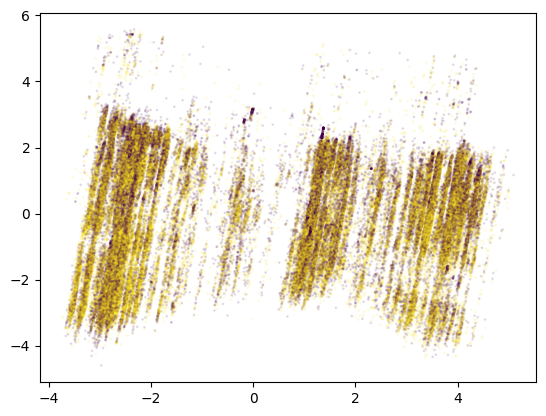

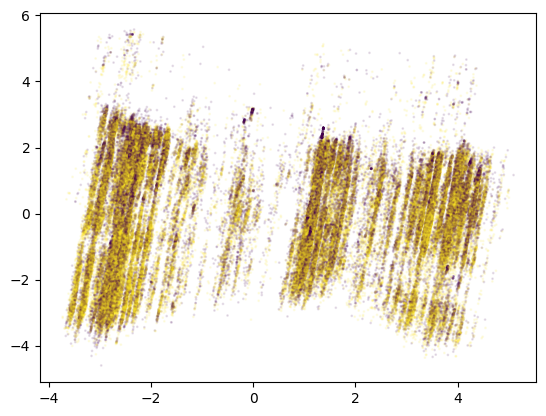

In [23]:
pca = util.view_pca(num_model_builder.X,num_model_builder.y)
Z = pca.fit_transform(num_model_builder.X)
fig, axs = plt.subplots()
axs.scatter(Z[:,0], Z[:,1], c=num_model_builder.y,s=1, alpha=0.1)
plt.show()

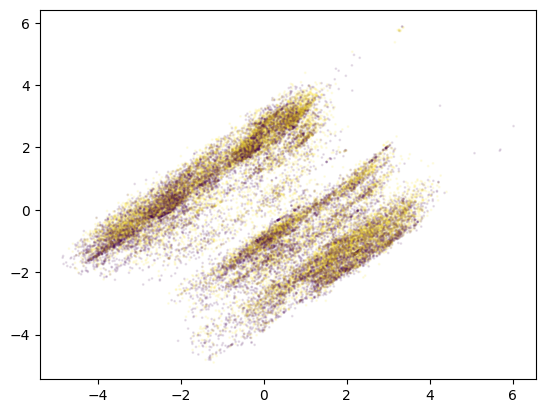

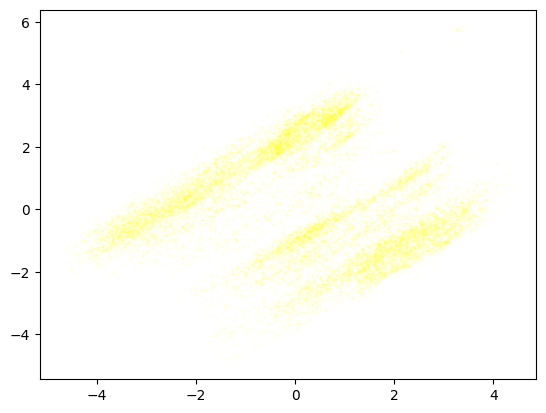

In [24]:
pca = util.view_pca(sd_model_builder.X_test,sd_model_builder.y_test)
Z = pca.fit_transform(sd_model_builder.X_test)
Z_c1 = Z[sd_model_builder.y_test==1]
fig, axs = plt.subplots()
axs.scatter(Z_c1[:,0], Z_c1[:,1], s=1, c="yellow",alpha=0.05)
plt.show()

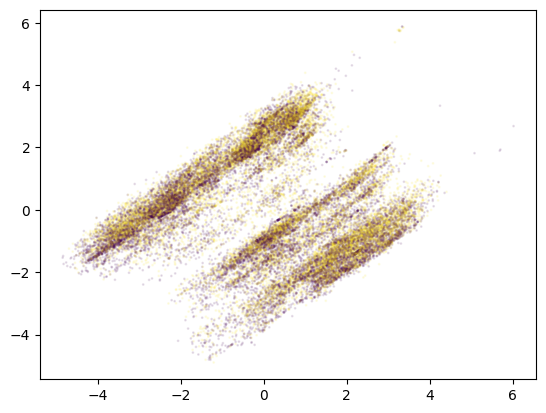

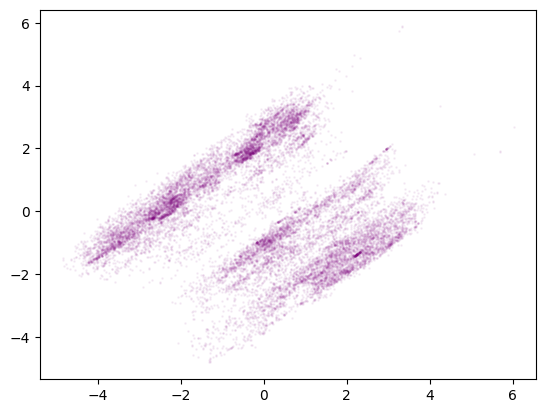

In [25]:
pca = util.view_pca(sd_model_builder.X_test,sd_model_builder.y_test)
Z = pca.fit_transform(sd_model_builder.X_test)
Z_c0 = Z[sd_model_builder.y_test==0]
fig, axs = plt.subplots()
axs.scatter(Z_c0[:,0], Z_c0[:,1], s=1,c="purple", alpha=0.05)
plt.show()

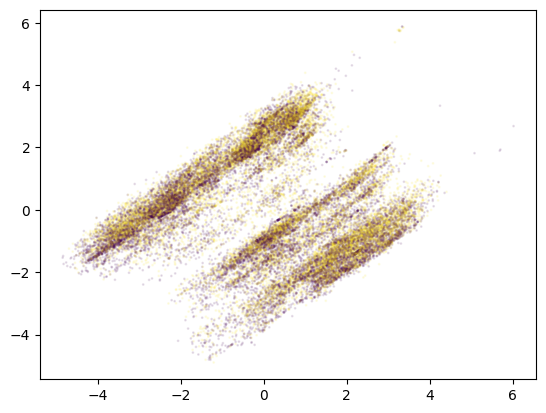

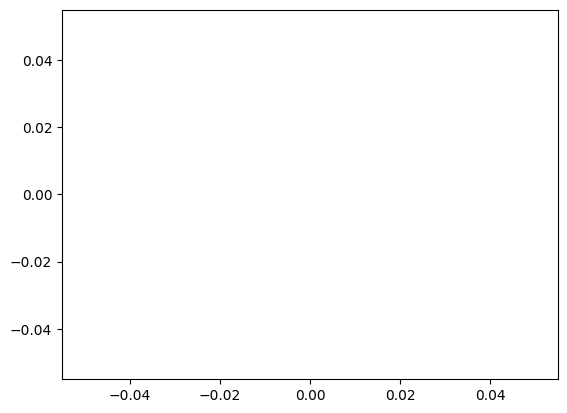

In [26]:
pca = util.view_pca(sd_model_builder.X_test,sd_model_builder.y_test)
Z = pca.fit_transform(sd_model_builder.X_test)
Z_c2 = Z[sd_model_builder.y_test==2]
fig, axs = plt.subplots()
axs.scatter(Z_c2[:,0], Z_c2[:,1], s=1, alpha=0.05)
plt.show()

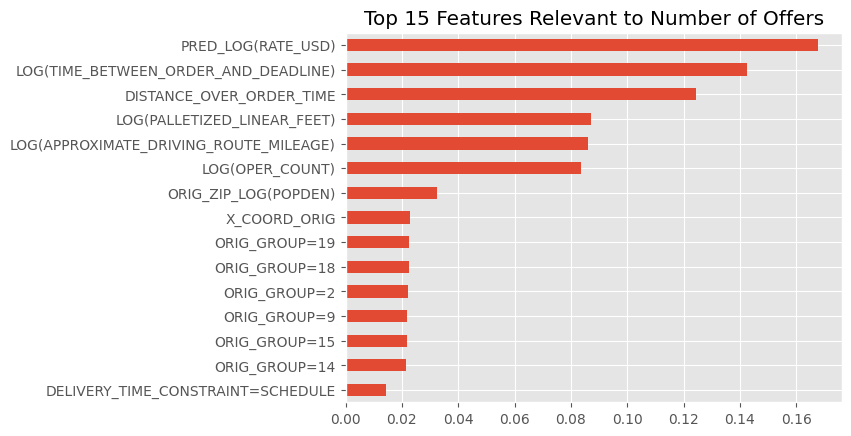

In [27]:
plt.style.use("ggplot")
fig, ax = plt.subplots()
pd.Series(
    index=num_model_builder.top_n_correlated_selected_column_names,
    data=num_model_builder.model.feature_importances_
).sort_values(ascending=False).head(15)[::-1].plot(kind="barh",ax=ax)
ax.set_title("Top 15 Features Relevant to Number of Offers")
plt.show()

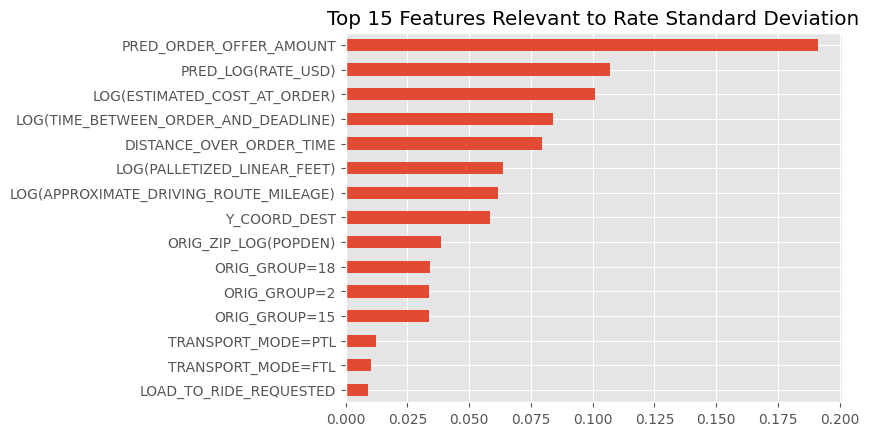

In [28]:
plt.style.use("ggplot")
fig, ax = plt.subplots()
pd.Series(
    index=sd_model_builder.top_n_correlated_selected_column_names,
    data=sd_model_builder.model.feature_importances_
).sort_values(ascending=False).head(15)[::-1].plot(kind="barh",ax=ax)
ax.set_title("Top 15 Features Relevant to Rate Standard Deviation")
plt.show()

In [29]:
from sklearn.model_selection import StratifiedKFold

def train_cross_val_model_averages(temp_model_builder):
    X = temp_model_builder.X_train.reset_index(drop=True)
    y = temp_model_builder.y_train.reset_index(drop=True)
    if (temp_model_builder.weight_column_name is None)==False:
        weight_column = temp_model_builder.X_train_weight_column
    
    N = 4
    skf = StratifiedKFold(n_splits=N,shuffle=True)
    splitted = skf.split(X, y)
    temp_models = []
    temp_accuracy_scores = []
    temp_roc_auc_scores = []
    for i, (train_index, test_index) in enumerate(splitted):
        temp_model = LogisticRegression(class_weight="balanced")
        x_train_fold, x_test_fold = X.values[train_index], X.values[test_index]
        y_train_fold, y_test_fold = y.values[train_index], y.values[test_index]
        if (temp_model_builder.weight_column_name is None)==False:
            weight_column_fold = weight_column[train_index]
            temp_model.fit(x_train_fold, y_train_fold,sample_weight=weight_column_fold)
        else:
            temp_model.fit(x_train_fold, y_train_fold)
        predictions = temp_model.predict(x_test_fold)
        temp_accuracy_score = np.mean(y_test_fold==predictions)
        temp_roc_auc_score = roc_auc_score(y_test_fold,predictions)
        temp_accuracy_scores.append(temp_accuracy_score)
        temp_roc_auc_scores.append(temp_roc_auc_score)
        print("Accuracy:", temp_roc_auc_score)
        print("ROC AUC:", temp_roc_auc_score)
        print("")
        temp_models.append(temp_model)

    model_coefs = np.array([model.coef_ for model in temp_models])
    print(model_coefs.shape)
    model_intercepts = np.array([model.intercept_ for model in temp_models])
    print(model_intercepts.shape)

    model_coefs = np.squeeze(model_coefs,1)
    print(model_coefs.shape)

    model_intercepts = np.squeeze(model_intercepts,1)
    print(model_intercepts.shape)

    model_coefs_std = np.std(model_coefs, axis=1, keepdims=1,ddof=0)

    model_coefs = model_coefs / model_coefs_std
    print(np.std(model_coefs,axis=1))
    model_coefs_avg = np.mean(model_coefs,axis=0)

    model_intercepts_ = model_intercepts / np.squeeze(model_coefs_std,1)
    model_intercepts_avg = np.mean(model_intercepts_)
    
    final_model = LogisticRegression()
    final_model.coef_ = model_coefs_avg
    final_model.intercept_ = model_intercepts_avg

    return final_model

#sd_new_model = train_cross_val_model_averages(sd_model_builder)

#sigmoid = lambda x: 1/(1+(np.exp(-x)))

#predictions_proba = sigmoid((sd_model_builder.X_test @ np.expand_dims(sd_new_model.coef_,1)+sd_new_model.intercept_))

#predictions = (predictions_proba > 0.5).astype(int)

#predictions = np.squeeze(predictions,1)

#print((sd_model_builder.y_test == predictions).mean())
#print(roc_auc_score(sd_model_builder.y_test, predictions))

In [41]:
fig, ax = plt.subplots()
ax.set_title("Top 15 Relevant Features to StDev of Offer Rates per Order")
pd.Series(
    index=sd_model_builder.top_n_correlated_selected_column_names,
    data=sd_model_builder.model.feature_importances_
).sort_values(ascending=False)[:15][::-1].plot(kind="barh",ax=ax)

<AxesSubplot:title={'center':'Top 15 Relevant Features to StDev of Offer Rates per Order'}>

In [42]:
fig, ax = plt.subplots()
ax.set_title("Top 15 Relevant Features to Number of Offers per Order")
pd.Series(
    index=num_model_builder.top_n_correlated_selected_column_names,
    data=num_model_builder.model.feature_importances_
).sort_values(ascending=False)[:15][::-1].plot(kind="barh",ax=ax)


<AxesSubplot:title={'center':'Top 15 Relevant Features to Number of Offers per Order'}>

In [43]:
fig, ax = plt.subplots()
ax.set_title("Top 15 Relevant Features to Avg of Offer Rates per Order")
pd.Series(
    index=avg_model_builder.top_n_correlated_selected_column_names,
    data=avg_model_builder.model.feature_importances_
).sort_values(ascending=False)[:15][::-1].plot(kind="barh",ax=ax)

<AxesSubplot:title={'center':'Top 15 Relevant Features to Avg of Offer Rates per Order'}>

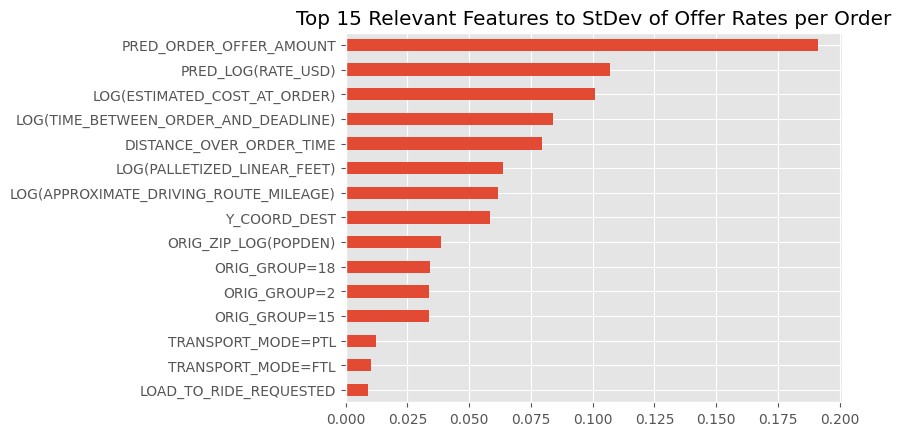

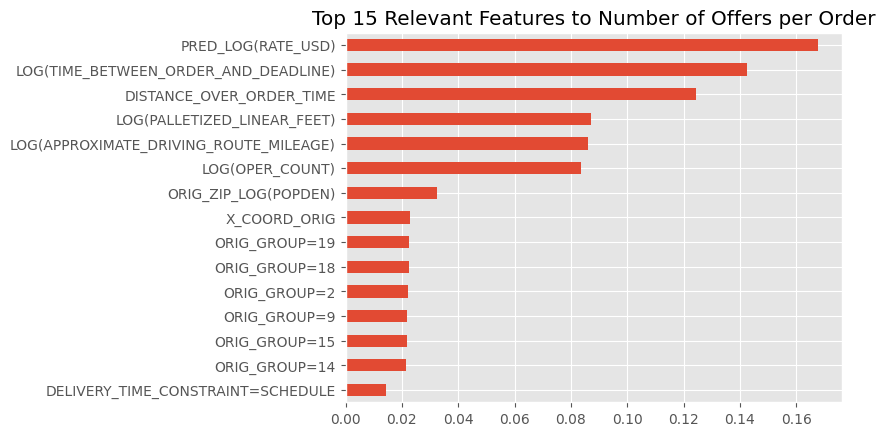

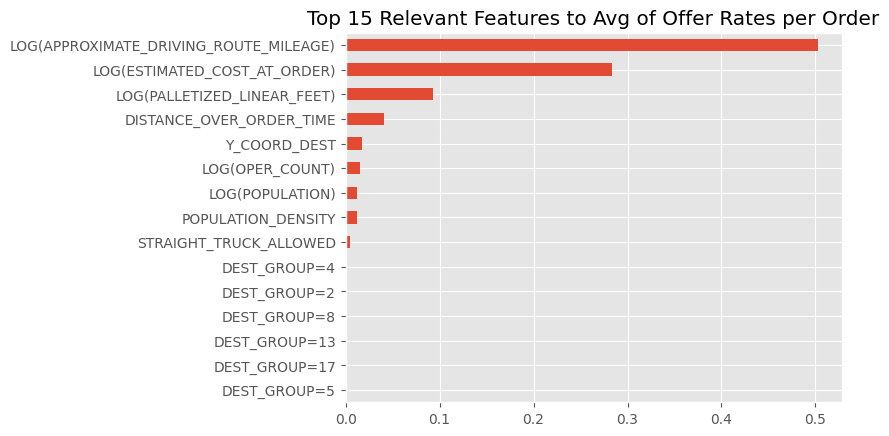

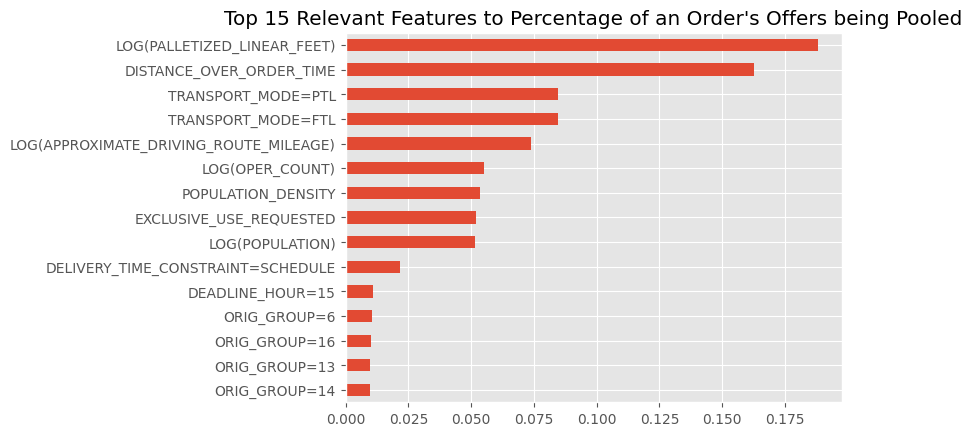

In [44]:
fig, ax = plt.subplots()
ax.set_title("Top 15 Relevant Features to Percentage of an Order's Offers being Pooled")
pd.Series(
    index=pooled_model_builder.top_n_correlated_selected_column_names,
    data=pooled_model_builder.model.feature_importances_
).sort_values(ascending=False)[:15][::-1].plot(kind="barh",ax=ax)
plt.show()